# Análise de Dados em Criptomoedas: Detecção de fraudes

---



**Professora:** Profa. Dra. Isadora Garcia Ferrão

📧 isadoraferrao@usp.br

🌐 [linkedin](https://www.linkedin.com/in/isadora-ferrao/)

🔗 [Instagram](https://www.instagram.com/isadora.ferrao/)

**Descrição dos Dados:** Os dados foram coletados de fontes públicas de monitoramento de carteiras e transações na rede Ethereum, como Etherscan, Dune Analytics e outras plataformas abertas. São dados reais e anonimizados, amplamente utilizados em estudos de detecção de fraude e análise de comportamento no mercado de criptomoedas. Cada linha representa uma carteira e suas métricas de atividade.

**Objetivo:** Construir um modelo preditivo capaz de identificar, com base nas métricas de transações, quando uma carteira apresenta comportamento anômalo, caracterizando uma potencial fraude.



## **Análise exploratória**

In [10]:
!python -m pip install pandas numpy matplotlib seaborn scikit-learn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --------------- ------------------------ 3.1/8.1 MB 18.5 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 22.7 MB/s eta 0:00:00
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------- ----------- 7.9/11.1 MB 40.4 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 29.0 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [13]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Configuração básica dos gráficos
plt.style.use('default')

In [3]:
# --- 1. Carregamento e limpeza dos dados ---
df = pd.read_csv('ethereum_transactions.csv.csv')

In [4]:
# Remover espaços em branco dos nomes das colunas
df.columns = df.columns.str.strip()

In [5]:
# Cria a coluna 'is_fraud' de forma direta:
# 1 se 'Sent tnx' for maior que (média + 2 * desvio padrão), senão 0
df["is_fraud"] = (df["Sent tnx"] > (df["Sent tnx"].mean() + 2 * df["Sent tnx"].std())).astype(int)

In [7]:
# Exibir informações iniciais para diagnóstico
print("Colunas do DataFrame", df.columns.tolist())
print(df.head())
print(df.describe())

Colunas do DataFrame ['Unnamed: 0', 'Index', 'Address', 'FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', 'Total ERC20 tnxs', 'ERC20 total Ether received', 'ERC20 total ether sent', 'ERC20 total Ether sent contract', 'ERC20 uniq sent addr', 'ERC20 uniq rec addr', 'ERC20 uniq sent addr.1', 'ERC20 uniq rec contract addr', 'ERC20 avg time between sent tnx', 'ERC20 avg time between rec tnx', 'ERC20 avg time between rec 2 tnx', 'ERC20 avg time between contract tnx',

## **Visualizando Correlações e Distribuições**

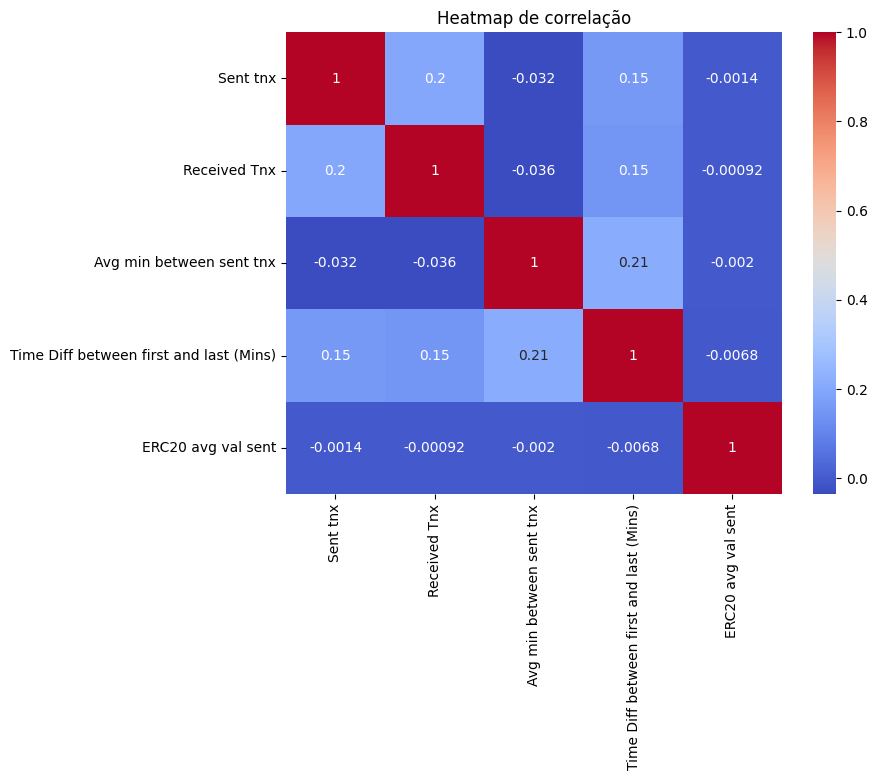

In [15]:
# Defina as colunas relevantes para a correlação
cols_for_corr = [
    "Sent tnx",
    "Received Tnx",
    "Avg min between sent tnx",
    "Time Diff between first and last (Mins)",
    "ERC20 avg val sent"
]

corr_matrix = df[cols_for_corr].corr()

# Plotando o heatmap de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Heatmap de correlação")
plt.show()

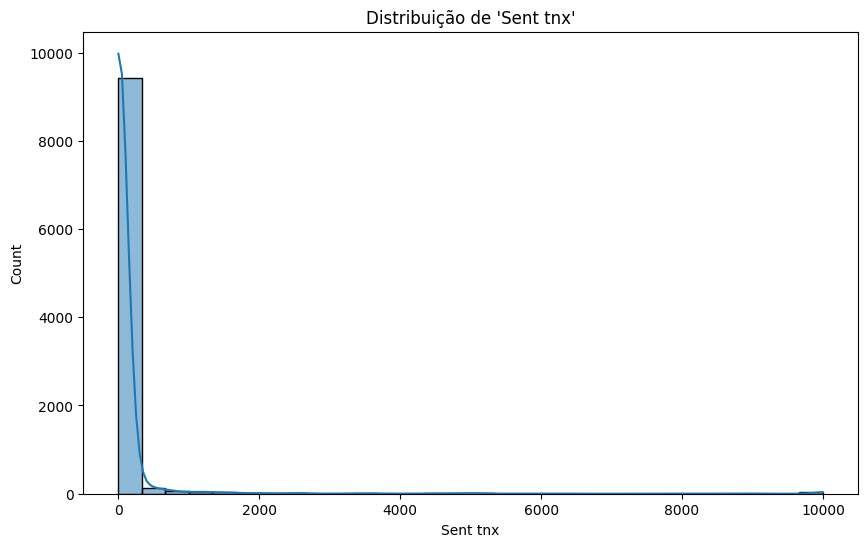

In [16]:
# Histogramas para visualizar a distribuição de 'Sent tnx'
plt.figure(figsize=(10, 6))
sns.histplot(df["Sent tnx"], bins=30, kde=True)
plt.xlabel("Sent tnx")
plt.title("Distribuição de 'Sent tnx'")
plt.show()



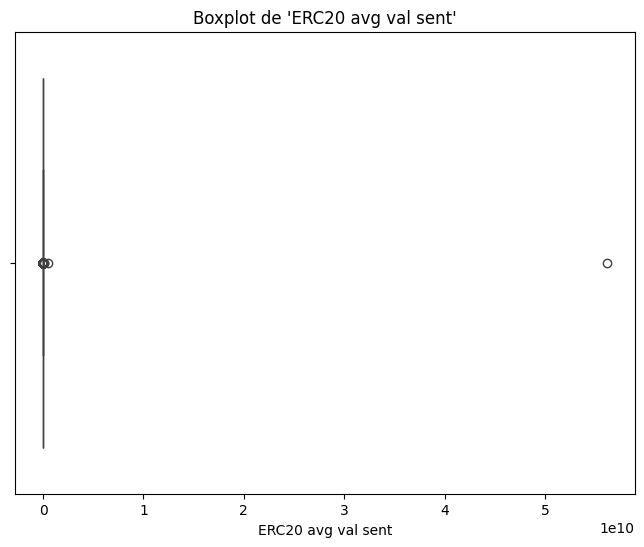

In [17]:
# Boxplot para identificar outliers em 'ERC20 avg val sent'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["ERC20 avg val sent"])
plt.xlabel("ERC20 avg val sent")
plt.title("Boxplot de 'ERC20 avg val sent'")
plt.show()


## **BASELINE**

In [20]:
# Calcular média e desvio padrão para 'Sent tnx'
mean_sent = df['Sent tnx'].mean()
std_sent = df['Sent tnx'].std()

threshold = mean_sent + 3 * std_sent
print(threshold, mean_sent, std_sent)

2387.6107960620707 115.93171425668123 757.2263606017965


In [22]:
# Marcar como anomalia as transações com 'Sent tnx' acima do threshold
df['baseline_anomaly'] = df ['Sent tnx'].apply(lambda x:1 if x > threshold else 0)

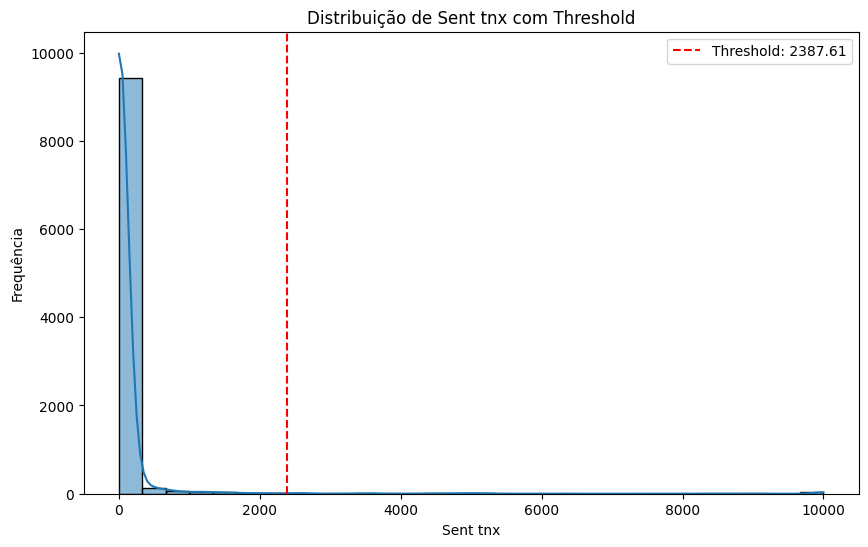

In [23]:
# Exibir histograma com o threshold
# Exibir histograma com o threshold
plt.figure(figsize=(10, 6))
sns.histplot(df["Sent tnx"], bins=30, kde=True)

plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.xlabel('Sent tnx')
plt.ylabel('Frequência')
plt.title('Distribuição de Sent tnx com Threshold')
plt.legend()
plt.show()



In [24]:
print("Número de anomalias (baseline):", df['baseline_anomaly'].sum())


Número de anomalias (baseline): 116


In [25]:
# Método Baseline:
print(classification_report(df['is_fraud'], df['baseline_anomaly']))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9697
           1       1.00      0.81      0.89       144

    accuracy                           1.00      9841
   macro avg       1.00      0.90      0.95      9841
weighted avg       1.00      1.00      1.00      9841



## **AULA 2 :)**